# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [145]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import count, col, when, isnan, udf, countDistinct, avg, when, col
from pyspark.sql.functions import max as sparkMax
from pyspark.sql.types import IntegerType, DoubleType
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [146]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

In [147]:
spark.conf.set('spark.executor.memory', '32gb')
spark.conf.set('spark.driver.memory','32gb')

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [148]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

In [149]:
df.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [150]:
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [151]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



First some columns that are not useful for the model can be dropped: firstName and lastName can be dropped since the userId uniquely identifies each user. Also, the artist and song columns can be dropped since they have no effect on user churn, since it is the pick of the user.

In [152]:
df.select([count(when(col(c)=="", c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [153]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [154]:
#drop rows with null values
df_clean = df.dropna(how='any',subset=['userId','sessionId'])
df_clean = df_clean.filter(df["userId"] != "")

In [155]:
df_clean.count()

278154

In [156]:
df.count()

286500

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [157]:
df_clean.select('auth').dropDuplicates().collect()

[Row(auth='Cancelled'), Row(auth='Logged In')]

In [158]:
df_clean.select('gender').dropDuplicates().collect()

[Row(gender='F'), Row(gender='M')]

In [159]:
df_clean.agg({'itemInSession':'max'}).collect()

[Row(max(itemInSession)=1321)]

In [160]:
df_clean.agg({'length':'max'}).collect()

[Row(max(length)=3024.66567)]

In [161]:
df_clean.select('level').dropDuplicates().collect()

[Row(level='free'), Row(level='paid')]

In [162]:
df_clean.select('location').dropDuplicates().show(10)

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
+--------------------+
only showing top 10 rows



In [163]:
df_clean.select('page').dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [164]:
df_clean.select('method').dropDuplicates().collect()

[Row(method='PUT'), Row(method='GET')]

In [165]:
df_clean.select('status').dropDuplicates().collect()

[Row(status=307), Row(status=404), Row(status=200)]

In [166]:
df_clean.select('userAgent').dropDuplicates().show(5)

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
+--------------------+
only showing top 5 rows



In [167]:
#users who made cancellation
df_canceled = df_clean.filter(df_clean.page == 'Cancellation Confirmation')
num_churn = df_canceled.count()
total_users = df_clean.select('userId').dropDuplicates().count()
print('percentage of churn: {:.2f}%'.format((num_churn/total_users)*100))

percentage of churn: 23.11%


In [168]:
#Define churn column
check_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0)
df_clean = df_clean.withColumn('churn',check_churn(df_clean.page).cast(DoubleType()) )
df_clean.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0.0)]

In [169]:
#look and the history for user 18 who churned
df_clean.select(["userId", "page", "ts", "level", "sessionId"]).where(df_clean.userId == 32).sort('ts').collect()

[Row(userId='32', page='NextSong', ts=1538578897000, level='free', sessionId=218),
 Row(userId='32', page='NextSong', ts=1538579134000, level='free', sessionId=218),
 Row(userId='32', page='NextSong', ts=1538579540000, level='free', sessionId=218),
 Row(userId='32', page='Roll Advert', ts=1538579565000, level='free', sessionId=218),
 Row(userId='32', page='NextSong', ts=1538579814000, level='free', sessionId=218),
 Row(userId='32', page='Thumbs Up', ts=1538579815000, level='free', sessionId=218),
 Row(userId='32', page='NextSong', ts=1538580056000, level='free', sessionId=218),
 Row(userId='32', page='Add to Playlist', ts=1538580068000, level='free', sessionId=218),
 Row(userId='32', page='NextSong', ts=1538580267000, level='free', sessionId=218),
 Row(userId='32', page='NextSong', ts=1538580477000, level='free', sessionId=218),
 Row(userId='32', page='NextSong', ts=1538581129000, level='free', sessionId=218),
 Row(userId='32', page='NextSong', ts=1538581369000, level='free', sessionId

In [170]:
churn_users = df_canceled.select('userId').collect() 
list_churn_users = [ row.userId for row in churn_users ]


In [171]:
df_sessions_per_user = df_clean.groupBy('userId').agg(countDistinct('sessionId').alias('sessions')).collect()

In [172]:
df_clean.groupBy(['userId','gender']).agg(countDistinct('sessionId').alias('sessions'), \
                               countDistinct(when(col('level')=='paid',col('sessionId'))).alias('paid_sessions'),\
                               countDistinct(when(col('level')=='free',col('sessionId'))).alias('free_sessions'),\
                               countDistinct('song').alias('songs'), \
                               count(when(col('page') =='Error', 1)).alias('errors'), \
                               count(when(col('page') =='Help', 1)).alias('help'), \
                               count(when((col('status') == 404)|(col('status') == 307), 1)).alias('resp_error'), \
                               count(when(col("churn")>0,True)).alias('churn'))\
                           .sort('userId').collect()

[Row(userId='10', gender='M', sessions=6, paid_sessions=6, free_sessions=0, songs=629, errors=0, help=1, resp_error=65, churn=0),
 Row(userId='100', gender='M', sessions=35, paid_sessions=29, free_sessions=8, songs=2302, errors=3, help=18, resp_error=269, churn=0),
 Row(userId='100001', gender='F', sessions=4, paid_sessions=0, free_sessions=4, songs=129, errors=1, help=1, resp_error=21, churn=1),
 Row(userId='100002', gender='F', sessions=4, paid_sessions=4, free_sessions=0, songs=193, errors=0, help=0, resp_error=7, churn=0),
 Row(userId='100003', gender='F', sessions=2, paid_sessions=0, free_sessions=2, songs=51, errors=0, help=1, resp_error=7, churn=1),
 Row(userId='100004', gender='F', sessions=21, paid_sessions=9, free_sessions=16, songs=881, errors=2, help=6, resp_error=93, churn=0),
 Row(userId='100005', gender='M', sessions=5, paid_sessions=0, free_sessions=5, songs=153, errors=0, help=2, resp_error=17, churn=1),
 Row(userId='100006', gender='F', sessions=1, paid_sessions=0, fr

In [173]:
agg = df_clean.groupBy(['userId','gender']).agg(countDistinct('sessionId').alias('sessions'), \
                               countDistinct(when(col('level')=='paid',col('sessionId'))).alias('paid_sessions'),\
                               countDistinct(when(col('level')=='free',col('sessionId'))).alias('free_sessions'),\
                               countDistinct('song').alias('songs'), \
                               count(when(col('page') =='Error', 1)).alias('errors'), \
                               count(when(col('page') =='Help', 1)).alias('help'), \
                               count(when((col('status') == 404)|(col('status') == 307), 1)).alias('resp_error'),\
                               count(when(col("churn")>0,True)).alias('churn'))\
                           .sort('userId').collect()
df_agg = spark.createDataFrame(agg)

In [174]:
pd_df = df_agg.toPandas()
pd_df = pd_df.set_index('userId')

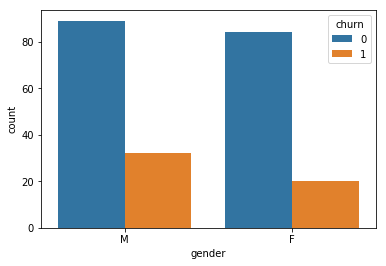

In [175]:
sns.countplot(x='gender', hue="churn", data=pd_df)

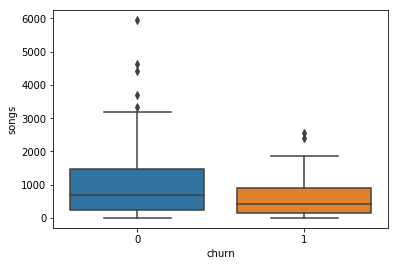

In [176]:
sns.boxplot(x='churn',y='songs',data=pd_df)

In [177]:
pd_df_canceled = df_canceled.toPandas()
x = pd_df_canceled['userId']
free_sessions = [ pd_df.loc[id,['free_sessions'][0]] for id in x]
paid_sessions = [ pd_df.loc[id,['paid_sessions'][0]] for id in x]


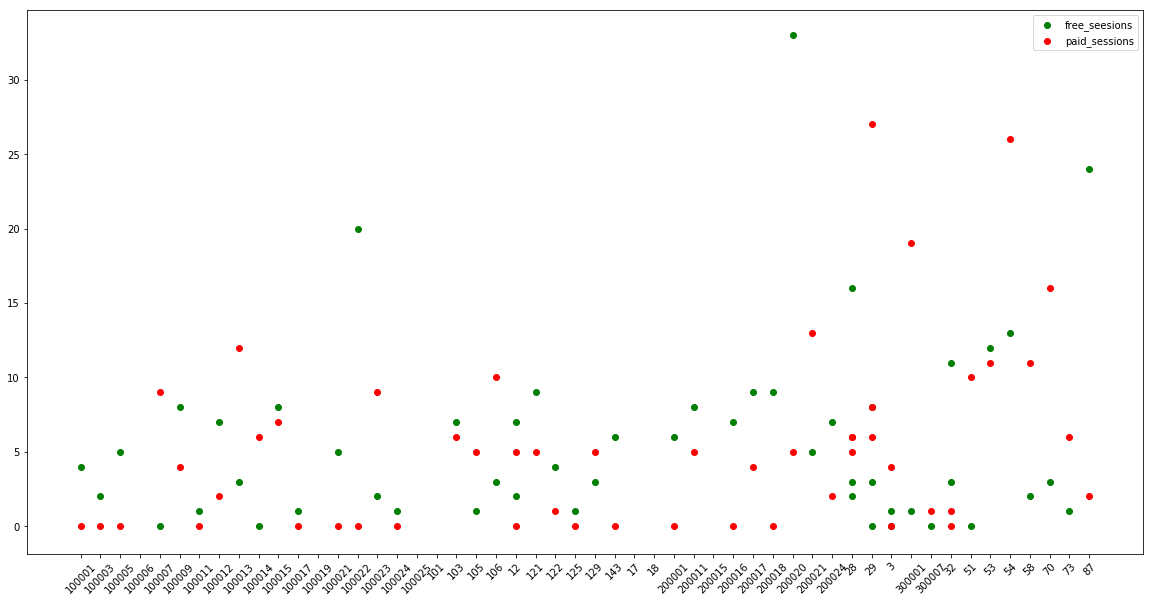

In [178]:
plt.figure(figsize=[20,10])
plt.scatter(x,free_sessions, c='g')
plt.scatter(x,paid_sessions, c='r')
plt.xticks(rotation=45)
plt.legend(['free_seesions','paid_sessions'])
plt.show()

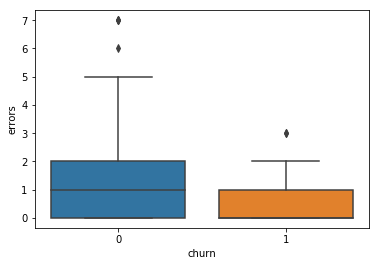

In [179]:
sns.boxplot(x='churn',y='errors',data=pd_df)

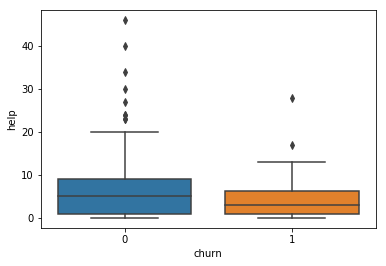

In [180]:
sns.boxplot(x='churn',y='help',data=pd_df)

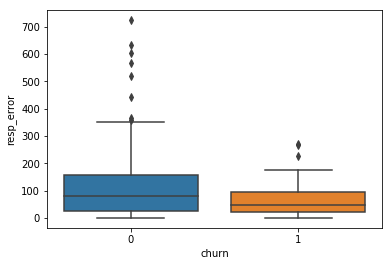

In [181]:
sns.boxplot(x='churn',y='resp_error',data=pd_df)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

To be able to work with the dataset we need to create a new dataframe with one row for each user, hence some changes needs to be conducted on the original features as follows:<br>
    - artist: is replace with number of artists
    - auth: dropped since the information is captured by the number of paid and free sessions
    - firstName: This column can be dropped since we have userId to distinguish each user
    - gender: replaced with two columns Female and Male with values 0 or 1 
    - itemInSession: is replaced with the avg(itemInSession) 
    - lastName: This column can be dropped since we have userId to distinguish each user
    - length: This column is replaced with the avg(length)
    - level: replaced with two columns free_sessions and paid_sessions  
    - location: can extract the state part of the location and then add a column for each state
    - method: is dropped
    - page: replaced with columns for each page type, in each column the number of times the page was browsed 
    - registration: replaced with col activeDuration; the number of days from registration until the last event
    - sessionId: replaced with two columns free_sessions and paid_sessions
    - song: replace with number of songs
    - status: replace with three columns:307,404 and 200 and each column contains a number represents the number of times the error appeared
    - ts: replaced with col activeDuration; the number of days from registration until the last event
    - userAgent: is dropped
    - userId: kept as is
After that we will check for null values and remove any column that a null values<br>
Note: from the page columns I didn't add page_NextPage column since its the same as number of songs, and I didn't add page_CancellationConfirmation since it is the same as the ChurnColumn

In [182]:
df_clean.groupBy(['userId','registration']).count().sort('userId').collect()

[Row(userId='10', registration=1538159495000, count=795),
 Row(userId='100', registration=1537982255000, count=3214),
 Row(userId='100001', registration=1534627466000, count=187),
 Row(userId='100002', registration=1529934689000, count=218),
 Row(userId='100003', registration=1537309344000, count=78),
 Row(userId='100004', registration=1528560242000, count=1245),
 Row(userId='100005', registration=1532610926000, count=216),
 Row(userId='100006', registration=1537964483000, count=44),
 Row(userId='100007', registration=1533522419000, count=520),
 Row(userId='100008', registration=1537440271000, count=940),
 Row(userId='100009', registration=1537376437000, count=671),
 Row(userId='100010', registration=1538016340000, count=381),
 Row(userId='100011', registration=1537970819000, count=23),
 Row(userId='100012', registration=1537381154000, count=600),
 Row(userId='100013', registration=1537367773000, count=1392),
 Row(userId='100014', registration=1535389443000, count=310),
 Row(userId='10

In [183]:
states = df_clean.select("location").distinct().rdd.flatMap(lambda x: list(x)).\
                                           flatMap(lambda loc:[loc.split(', ',1)[-1]]).\
                                           flatMap(lambda state: state.split('-')).collect()

In [184]:
states = set(states)
states = list(states)

In [185]:
to_int = udf(lambda x: int(x))
final = df_clean.groupBy(['userId','gender','location']).agg(countDistinct('artist').alias('artists'),\
                                 avg('itemInSession').alias('avgItemInSession'),\
                                 avg('length').alias('avgLength'),\
                                 to_int((sparkMax('ts')-sparkMax('registration'))/86400).alias('activeDuration'),\
                                 countDistinct(when(col('level')=='paid',col('sessionId'))).alias('paid_sessions'),\
                                 countDistinct(when(col('level')=='free',col('sessionId'))).alias('free_sessions'),\
                                 countDistinct('song').alias('songs'), \
                                 count(when(col('status') == 404,1)).alias('resp_404'),\
                                 count(when(col('status') == 307,1)).alias('resp_307'),\
                                 count(when(col('status') == 200,1)).alias('resp_200'),\
                                 count(when(col('page') =='Error', 1)).alias('page_error'), \
                                 count(when(col('page') =='Help', 1)).alias('page_help'), \
                                 count(when(col('page') =='Cancel', 1)).alias('page_cancel'), \
                                 count(when(col('page') =='Submit Downgrade', 1)).alias('page_submitDowngrade'), \
                                 count(when(col('page') =='Thumbs Down', 1)).alias('page_thumpDown'), \
                                 count(when(col('page') =='Home', 1)).alias('page_home'), \
                                 count(when(col('page') =='Downgrade', 1)).alias('page_downgrade'), \
                                 count(when(col('page') =='Roll Advert', 1)).alias('page_rollAdvert'), \
                                 count(when(col('page') =='Logout', 1)).alias('page_logout'), \
                                 count(when(col('page') =='Save Settings', 1)).alias('page_saveSettings'), \
                                 count(when(col('page') =='About', 1)).alias('page_about'), \
                                 count(when(col('page') =='Settings', 1)).alias('page_settings'), \
                                 count(when(col('page') =='Add to Playlist', 1)).alias('page_addtoPlaylist'), \
                                 count(when(col('page') =='Add Friend', 1)).alias('page_addFriend'), \
                                 count(when(col('page') =='Thumbs Up', 1)).alias('page_thumpsUp'), \
                                 count(when(col('page') =='Upgrade', 1)).alias('page_upgrade'), \
                                 count(when(col('page') =='Submit Upgrade', 1)).alias('page_submitUpgrade'), \
                                 count(when(col("churn")>0,True)).alias('churn'))\
                           .sort('userId').collect()
df_final = spark.createDataFrame(final)

In [186]:
isMale = udf(lambda x: 1 if x == 'M' else 0)
isFemale = udf(lambda x: 1 if x == 'F' else 0)
df_final = df_final.withColumn('Male', isMale('gender').cast(IntegerType())).withColumn('Femal', isFemale('gender').cast(IntegerType())).drop('gender')

In [187]:
def is_in_state(state):
    def check(x):
        if state in x.split(', ',1)[-1].split('-'): 
            return 1
        else:
            return 0
    return udf(check, IntegerType() )
for state in states:
    df_final = df_final.withColumn(state, is_in_state(state)('location'))

In [188]:
df_final = df_final.drop('location')

In [189]:
df_final = df_final.withColumn("id", df_final["userId"].cast('int')).drop('userId')

In [190]:
df_final = df_final.withColumn("active", df_final["activeDuration"].cast('int')).drop('activeDuration')

In [191]:
df_final.show(5)

+-------+------------------+------------------+-------------+-------------+-----+--------+--------+--------+----------+---------+-----------+--------------------+--------------+---------+--------------+---------------+-----------+-----------------+----------+-------------+------------------+--------------+-------------+------------+------------------+-----+----+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+---+---+---+---+---+---+---+------+
|artists|  avgItemInSession|         avgLength|paid_sessions|free_sessions|songs|resp_404|resp_307|resp_200|page_error|page_help|page_cancel|page_submitDowngrade|page_thumpDown|page_home|page_downgrade|page_rollAdvert|page_logout|page_saveSettings|page_about|page_settings|page_addtoPlaylist|page_addFriend|page_thumpsUp|page_upgrade|page_submitUpgrade|churn|Male|Femal| KY| RI| MO| NJ| WA| OR| MA| CA| WI| UT| NY| WV| AL| KS| NV| MT| IA| OH| 

In [192]:
df_final.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_final.columns]).show()

+-------+----------------+---------+-------------+-------------+-----+--------+--------+--------+----------+---------+-----------+--------------------+--------------+---------+--------------+---------------+-----------+-----------------+----------+-------------+------------------+--------------+-------------+------------+------------------+-----+----+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+
|artists|avgItemInSession|avgLength|paid_sessions|free_sessions|songs|resp_404|resp_307|resp_200|page_error|page_help|page_cancel|page_submitDowngrade|page_thumpDown|page_home|page_downgrade|page_rollAdvert|page_logout|page_saveSettings|page_about|page_settings|page_addtoPlaylist|page_addFriend|page_thumpsUp|page_upgrade|page_submitUpgrade|churn|Male|Femal| KY| RI| MO| NJ| WA| OR| MA| CA| WI| UT| NY| WV| AL| KS| NV| MT| IA| OH| NE| GA| TN| AR| LA| SC| C

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [194]:
df_ready = df_final

In [195]:
X = df_ready.drop('churn')
y = df_ready.select('churn')

In [196]:
train, test = df_ready.randomSplit([0.7, 0.3], seed=0)

In [197]:
features_col = [col for col in X.columns]
def build_model(classifier, param):
    assembler = VectorAssembler(inputCols=features_col, outputCol="features", handleInvalid='skip')
    normalizer = Normalizer(inputCol="features", outputCol="normFeatures")
    pipeline = Pipeline(stages=[assembler,normalizer,classifier ])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=5,
    )
    return model

In [198]:
classifier = RandomForestClassifier(featuresCol="normFeatures", labelCol="churn")
classifier_param = ParamGridBuilder().build()
classifier_model = build_model(classifier, classifier_param)

In [199]:
classifier_fit_model = classifier_model.fit(train)

In [200]:
pred = classifier_fit_model.transform(test)

In [201]:
pred.printSchema()

root
 |-- artists: long (nullable = true)
 |-- avgItemInSession: double (nullable = true)
 |-- avgLength: double (nullable = true)
 |-- paid_sessions: long (nullable = true)
 |-- free_sessions: long (nullable = true)
 |-- songs: long (nullable = true)
 |-- resp_404: long (nullable = true)
 |-- resp_307: long (nullable = true)
 |-- resp_200: long (nullable = true)
 |-- page_error: long (nullable = true)
 |-- page_help: long (nullable = true)
 |-- page_cancel: long (nullable = true)
 |-- page_submitDowngrade: long (nullable = true)
 |-- page_thumpDown: long (nullable = true)
 |-- page_home: long (nullable = true)
 |-- page_downgrade: long (nullable = true)
 |-- page_rollAdvert: long (nullable = true)
 |-- page_logout: long (nullable = true)
 |-- page_saveSettings: long (nullable = true)
 |-- page_about: long (nullable = true)
 |-- page_settings: long (nullable = true)
 |-- page_addtoPlaylist: long (nullable = true)
 |-- page_addFriend: long (nullable = true)
 |-- page_thumpsUp: long (nul

In [202]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
f1_score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
print("f1: {}".format(f1_score))

f1: 0.9678544494720964


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [203]:
def create_session():
    '''
        creates a new spark session locally
        input:()
        output:(
            spark: a pointer to the newly created spark session
        )
    '''
    spark = SparkSession.builder \
        .master("local") \
        .appName("Sparkify") \
        .getOrCreate()
    spark.conf.set('spark.executor.memory', '32gb')
    spark.conf.set('spark.driver.memory','32gb')
    return spark


In [204]:
def load_clean_data(spark, file):
    '''
        creates a new spark session locally
        input:(
            spark: The spark session,
            file: String - The path to the file containing data 
        )
        output:(
            df_clean: DataFrame - Dataframe contining loaded data after removing null and empty string 
                      values
    '''
    sparkify_datail = file
    df = spark.read.json(sparkify_data)
    df.persist()
    #drop rows with null values
    df_clean = df.dropna(how='any',subset=['userId','sessionId'])
    df_clean = df_clean.filter(df["userId"] != "")
    return df_clean

In [208]:
def is_in_state(state):
    def check(x):
        if state in x.split(', ',1)[-1].split('-'): 
            return 1
        else:
            return 0
    return udf(check, IntegerType() )

    
def extract_features(spark, df_clean):
    '''
        Extract featured appropriate for training the model
        input:(
            spark: The spark session,
            df_clean: DataFrame - Dataframe containing clean data 
        )
        output:(
            df_final: DataFrame - Dataframe contining the extracted features
    '''
           
    #add churn column
    check_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0)
    df_clean = df_clean.withColumn('churn',check_churn(df_clean.page).cast(DoubleType()) )
    
    #create df_final with aggregate features
    to_int = udf(lambda x: int(x))
    final = df_clean.groupBy(['userId','gender','location']).agg(countDistinct('artist').alias('artists'),\
                                 avg('itemInSession').alias('avgItemInSession'),\
                                 avg('length').alias('avgLength'),\
                                 to_int((sparkMax('ts')-sparkMax('registration'))/86400).alias('activeDuration'),\
                                 countDistinct(when(col('level')=='paid',col('sessionId'))).alias('paid_sessions'),\
                                 countDistinct(when(col('level')=='free',col('sessionId'))).alias('free_sessions'),\
                                 countDistinct('song').alias('songs'), \
                                 count(when(col('status') == 404,1)).alias('resp_404'),\
                                 count(when(col('status') == 307,1)).alias('resp_307'),\
                                 count(when(col('status') == 200,1)).alias('resp_200'),\
                                 count(when(col('page') =='Error', 1)).alias('page_error'), \
                                 count(when(col('page') =='Help', 1)).alias('page_help'), \
                                 count(when(col('page') =='Cancel', 1)).alias('page_cancel'), \
                                 count(when(col('page') =='Submit Downgrade', 1)).alias('page_submitDowngrade'), \
                                 count(when(col('page') =='Thumbs Down', 1)).alias('page_thumpDown'), \
                                 count(when(col('page') =='Home', 1)).alias('page_home'), \
                                 count(when(col('page') =='Downgrade', 1)).alias('page_downgrade'), \
                                 count(when(col('page') =='Roll Advert', 1)).alias('page_rollAdvert'), \
                                 count(when(col('page') =='Logout', 1)).alias('page_logout'), \
                                 count(when(col('page') =='Save Settings', 1)).alias('page_saveSettings'), \
                                 count(when(col('page') =='About', 1)).alias('page_about'), \
                                 count(when(col('page') =='Settings', 1)).alias('page_settings'), \
                                 count(when(col('page') =='Add to Playlist', 1)).alias('page_addtoPlaylist'), \
                                 count(when(col('page') =='Add Friend', 1)).alias('page_addFriend'), \
                                 count(when(col('page') =='Thumbs Up', 1)).alias('page_thumpsUp'), \
                                 count(when(col('page') =='Upgrade', 1)).alias('page_upgrade'), \
                                 count(when(col('page') =='Submit Upgrade', 1)).alias('page_submitUpgrade'), \
                                 count(when(col("churn")>0,True)).alias('churn'))\
                           .sort('userId').collect()
    df_final = spark.createDataFrame(final)
    
    #create dummy columns for the gender column Male or Female
    isMale = udf(lambda x: 1 if x == 'M' else 0)
    isFemale = udf(lambda x: 1 if x == 'F' else 0)
    df_final = df_final.withColumn('Male', isMale('gender').cast(IntegerType())).withColumn('Femal', isFemale('gender').cast(IntegerType())).drop('gender')                                       
      
    
    #create dummy columns for the state of the user
    #read the list of states
    states = df_clean.select("location").distinct().rdd.flatMap(lambda x: list(x)).\
                                           flatMap(lambda loc:[loc.split(', ',1)[-1]]).\
                                           flatMap(lambda state: state.split('-')).collect()
    states = set(states)
    states = list(states)
    
    for state in states:
        df_final = df_final.withColumn(state, is_in_state(state)('location'))
    df_final = df_final.drop('location')
    
    #convert userId column to int
    df_final = df_final.withColumn("id", df_final["userId"].cast('int')).drop('userId')
    
    #convert activeDuration column to int
    df_final = df_final.withColumn("active", df_final["activeDuration"].cast('int')).drop('activeDuration') 
    
    return df_final
    

In [209]:
def build_model(classifier, param,features_col):
    '''
        Builds the model used for training the data
        input:(
            classifier: The classifier used for training the model,
            params: Parameters to be used for training the model as returned by ParamGridBuilder
        )
        output:(
            model: The model to be used for training the data
    '''
    assembler = VectorAssembler(inputCols=features_col, outputCol="features", handleInvalid='skip')
    normalizer = Normalizer(inputCol="features", outputCol="normFeatures")
    pipeline = Pipeline(stages=[assembler,normalizer,classifier ])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=5,
    )
    return model

In [213]:
def train_model(df_ready):
    '''
        Trains the model
        input:(
            df_ready: DataFrame - The dataframe containinf features to train the modelridBuilder
        )
        output:(
            classifier_fit_model: The model after training 
    '''
    X = df_ready.drop('churn')
    y = df_ready.select('churn')
    train, test = df_ready.randomSplit([0.7, 0.3], seed=0)
    features_col = [col for col in X.columns]
    classifier = RandomForestClassifier(featuresCol="normFeatures", labelCol="churn")
    classifier_param = ParamGridBuilder().build()
    classifier_model = build_model(classifier, classifier_param, features_col)
    classifier_fit_model = classifier_model.fit(train)
    return classifier_fit_model

In [214]:
def test_model(fit_model):
    '''
        Test and evaluate the model using f1_score
        input:(
            fit_model: The trained model
        )
        output:(
            f1_score: float - The f1-score calculated after testing the model
    '''
    pred = fit_model.transform(test)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
    f1_score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    
    return f1_score

In [215]:
spark = create_session()
sparkify_data = 'mini_sparkify_event_data.json'
df_clean = load_clean_data(spark, sparkify_data)
df_ready = extract_features(spark, df_clean)
classifier_fit_model = train_model(df_ready)
f1_score = test_model(classifier_fit_model)
print("f1: {}".format(f1_score))

f1: 0.9678544494720964
